# STFT experiments

## 1 - Implementation using Numpy

Based on [Time-frequency analysis with Short-time Fourier transform](http://tsaith.github.io/time-frequency-analysis-with-short-time-fourier-transform.html)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Plot settings
plt.rcParams['figure.figsize'] = (20, 15) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams.update({'font.size': 22})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# STFT function
def stft(x, fs, frame_size, hop):
  """
  Perform STFT (Short-Time Fourier Transform).

  x: Input data.
  fs: Sampling rate.
  frame_size: Frame size.
  hop: Hop size
  """

  frame_samp = int(frame_size*fs)
  hop_samp = int(hop*fs)
  w = np.hanning(frame_samp) # Hanning window
  X = np.array([np.fft.fft(w*x[i:i+frame_samp])
               for i in range(0, len(x)-frame_samp, hop_samp)])
  return X

In [5]:
# Inverse STFT function
def istft(X, fs, T, hop):
  """
  Perform inverse STFT (Short-Time Fourier Transform).

  X: Input data.
  fs: Sampling rate.
  T: Total time duration.
  hop: Hop size.
  """

  x = np.zeros(T*fs)
  frame_samp = X.shape[1]
  hop_samp = int(hop*fs)

  for n,i in enumerate(range(0, len(x)-frame_samp, hop_samp)):
    x[i:i+frame_samp] += np.real(np.fft.ifft(X[n]))

  return x

In [7]:
# Simulated sinusoidal wave
def simu_waves(f, dt, amp0=1, phi0=0):
  """
  Return the simulated waves.
  y(t) = amp0 * cos(phi(t) + phi0), 
  where phi(t) = 2 * pi * \int_0^t f(t) * dt. 
    
  f: Instantaneous frequencies.
  dt: Time interval.
  amp0: Amplitude.
  phi0: Initail phase. When it is -pi/2, sin waves are produced.  
  """
    
  phi = 2 * np.pi * np.cumsum(f) * dt
  y = amp0*np.cos(phi+ phi0)
    
  return y

In [9]:
# Simulated sawtooth signal
def simu_freq_sawtooth(t, fm=1, B=1, fd=0, width=0.5):
    '''
    Simulated frequencies of sawtooth modulation.

    t: Time array.
    fm: Modulation frequency.
    fd: Doppler frequency shift.
    B: Bandwidth.
    '''
    f = B*0.5*(signal.sawtooth(2 * np.pi * fm * t, width=width) + 1)
    f += fd
    return f

Text(0, 0.5, 'Frequency (Hz)')

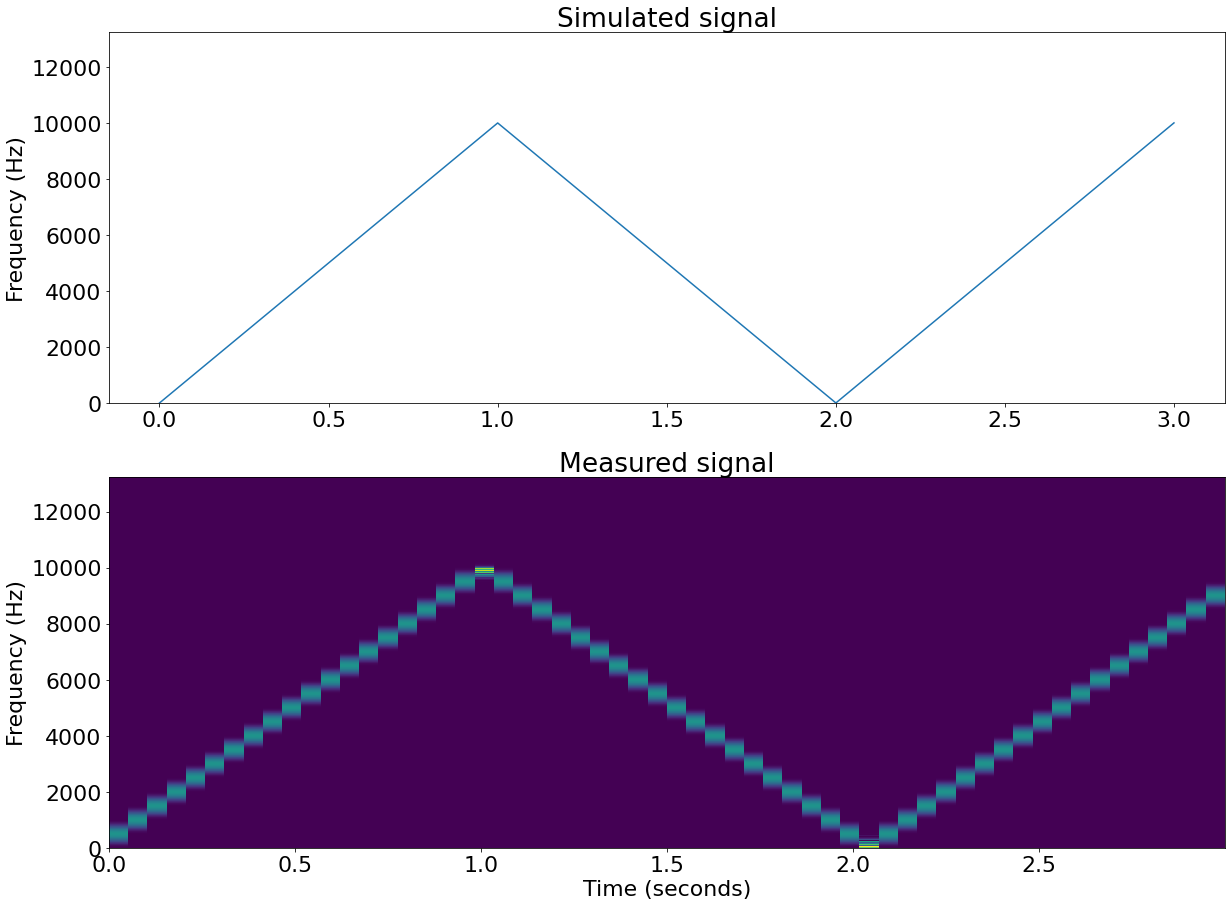

In [15]:
# Example of STFT analysis
T = 3    # Time duration in (second) (default was 10 seconds)
fs = 44100 # Sampling rate (Hz) (default was 4000 Hz)
fm = 0.5  # Frequency of modulation (Hz) (default was 0.2 Hz)
B = 10000  # Bandwidth (Hz) (default was 1000 Hz)

frame_size = 0.100  # with a frame size of 100 milliseconds (default was 50 ms)
hop = 0.050         # and hop size of 50 milliseconds (50% overlap) (default was 25 ms)
    
t = np.linspace(0, T, T*fs, endpoint=False)
dt = t[1] - t[0]
f = simu_freq_sawtooth(t, fm, B, fd=0, width=0.5)
y = simu_waves(f, dt, amp0=1)      
Y = stft(y, fs, frame_size, hop)

# Plot time-frequency relation
t_min = t[0]
t_max = t[-1]
f_min = 0
f_max = int(fs * 0.3)

plt.figure(figsize=(20, 15))

ax = plt.subplot(2, 1, 1)
plt.plot(t, f)
plt.title('Simulated signal')
plt.ylim(t_min, t_max)
plt.ylim(f_min, f_max)
plt.ylabel('Frequency (Hz)')

ax = plt.subplot(2, 1, 2)
Fz = int(frame_size * fs *0.3 )
ax.imshow(np.absolute(Y[:, :Fz].T), origin='lower', 
          aspect='auto', interpolation='nearest', extent=[t_min, t_max, f_min, f_max])
plt.title('Measured signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

# 2 - Implementation using SciPy

In [54]:
from IPython.display import Audio
import librosa
import scipy

plt.rcParams['figure.figsize'] = (20, 10) # set default size of plots
plt.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings('ignore')

In [83]:
# Load audio file
file_path = '../mp3/chords/Am.mp3'
samples, fs = librosa.load(file_path, sr = None, offset = 0.0, duration = None)

print('Audio loaded. Duration %.2f seconds - Samples %d - Sampling rate (fs) %d Hz' %
      (len(samples)/fs, len(samples), fs))

Audio(file_path)

Audio loaded. Duration 2.27 seconds - Samples 100224 - Sampling rate (fs) 44100 Hz


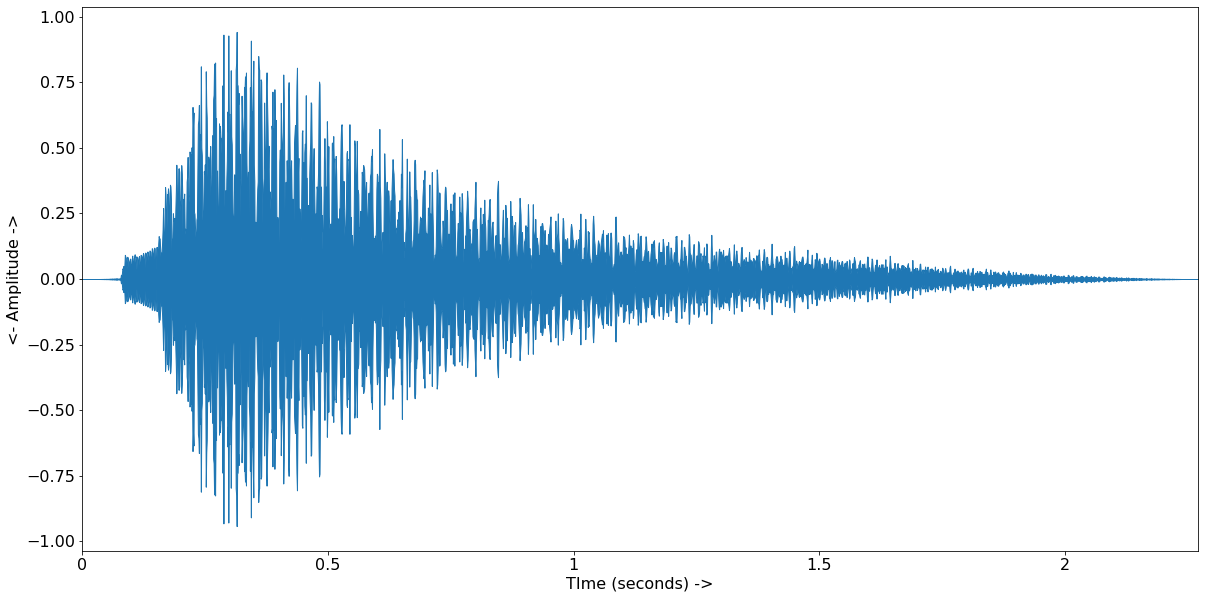

In [56]:
plt.figure()
librosa.display.waveplot(y = samples, sr = fs)
plt.xlabel('TIme (seconds) ->')
plt.ylabel('<- Amplitude ->')
plt.show()

In [68]:
def fft_plot(audio, fs, fmax=None):
    n = len(audio)
    T = 1/fs
    yf = scipy.fft(audio)
    xf = np.linspace(0.0, 1.0/(2.0*T), n//2)
    fig, ax = plt.subplots()
    yf_abs = 2.0/n * np.abs(yf[:n//2])
    if fmax:
        idx = (np.abs(xf - fmax)).argmin()
        xf = xf[:idx+1]
        yf_abs = yf_abs[:idx+1]
    ax.plot(xf, yf_abs)
    plt.grid()
    plt.xlabel('Frequency ->')
    plt.ylabel('Magnitude ->')
    return plt.show()

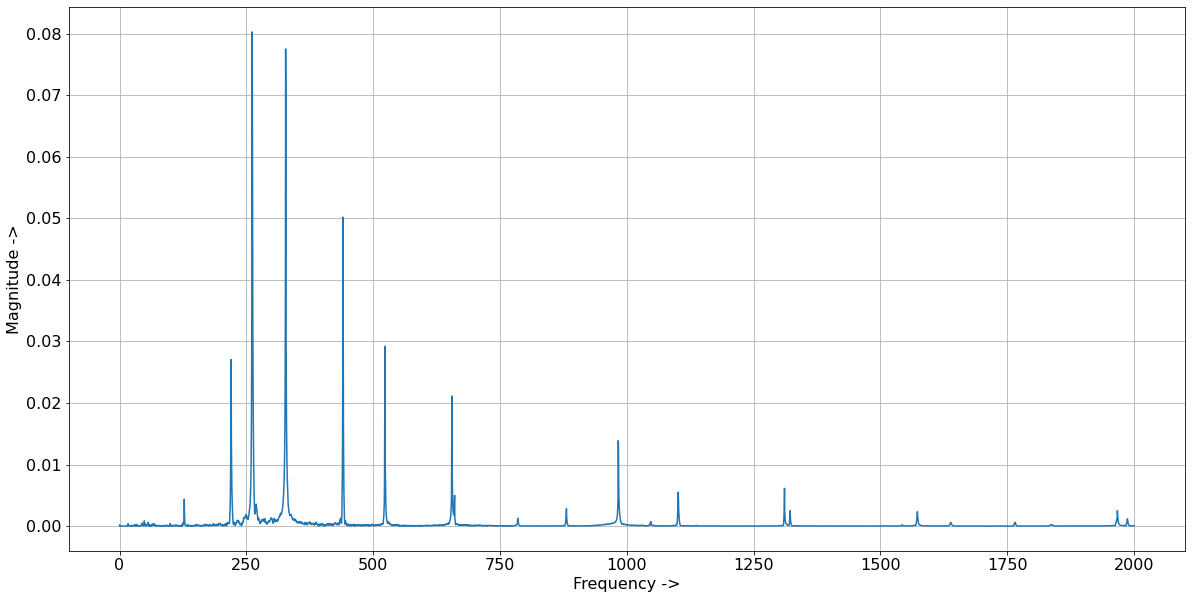

In [70]:
fft_plot(samples, fs, fmax = 2000)

In [95]:
f, t, sp = scipy.signal.spectrogram(x=samples, fs=fs, nfft=4096, noverlap=2048, nperseg=4096, 
                                    mode='magnitude', scaling='spectrum')

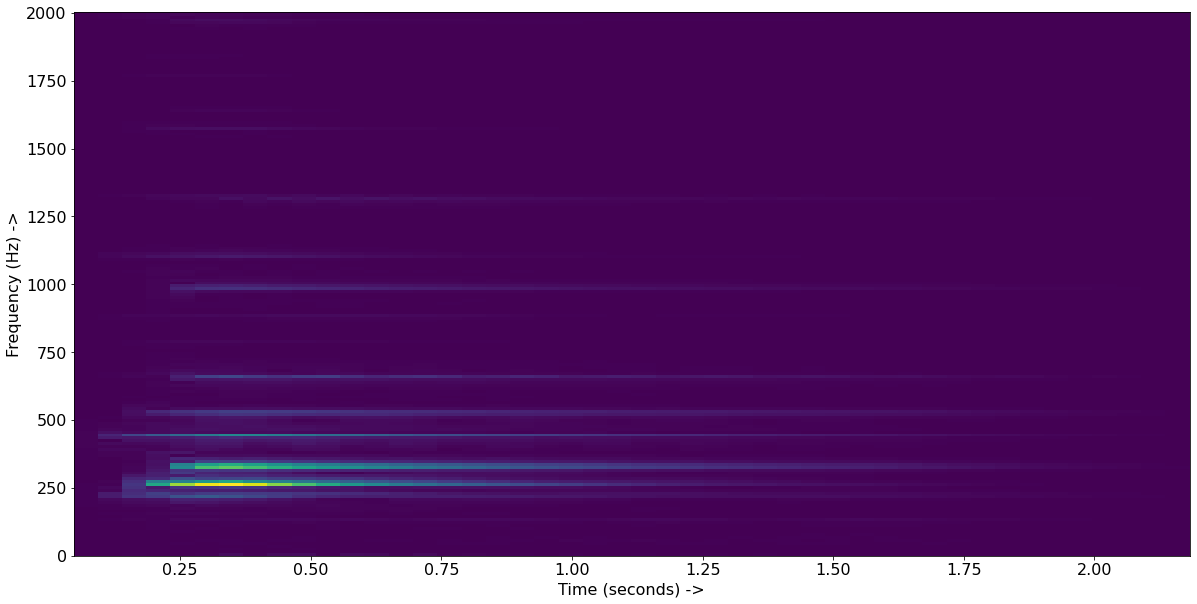

In [107]:
fmax = 2000
idx = (np.abs(f - fmax)).argmin()

plt.pcolormesh(t, f[:idx+1], sp[:idx+1,:])
plt.ylabel('Frequency (Hz) ->')
plt.xlabel('Time (seconds) ->')
plt.show()

In [108]:
f = [0.00027234654, 0.0017401886, 0.0064861337, 0.006006314, 0.0027445205, 0.006426834, 0.00768119, 0.0036890095, 0.0014736648, 0.005007435, 0.022145603, 0.02916736, 0.014032303, 0.005353832, 0.005467179, 0.0019336119, 0.00199544, 0.0034155229, 0.006870346, 0.013099915, 0.0435184, 0.058228917, 0.021393307, 0.00946338, 0.0042863204, 0.002088422, 0.0032793032, 0.0024896048, 0.0046114526, 0.0016437623, 0.004023331, 0.0019417757, 0.004573688, 0.009505124, 0.014929862, 0.009865726, 0.001858717, 0.0020166363, 0.0030678085, 0.0024188298, 0.0006463855, 0.0012349507, 0.0041718893, 0.010819883, 0.023188096, 0.0061224424, 0.005247404, 0.0060018334, 0.0022354936, 0.0022513568, 0.008656361, 0.014056312, 0.018069806, 0.021636492, 0.0099246325, 0.007062198, 0.002567762, 0.006130824, 0.004826481, 0.0023358604, 0.0024011016, 0.004894463, 0.0050319796, 0.0028983955, 0.004949241, 0.0031365394, 0.003290055, 0.003100557, 0.0011669147, 0.0003529974, 0.0006699241, 0.0008520333, 0.0006076219, 0.0008064367, 0.001033404, 0.0010540461, 0.00018363849, 0.0005342026, 0.001900043, 0.0020982048, 0.0006709015, 0.0013480368, 0.0011630333, 0.0010078342, 0.0010060931, 0.00043330033, 0.0007034511, 0.0009042954, 0.0004603567, 0.00031554626, 0.0013423954, 0.0016280541, 0.00089363416, 0.0011373183, 0.0019739198, 0.0011593795, 0.0011832021, 0.0010332033, 0.0014617658, 0.0013610272, 0.0009888595, 0.0007310153, 0.0011572033, 0.0011566828, 0.0009815524, 0.00036321857, 0.0015369128, 0.0006691645, 0.00068210514, 0.0008372373, 7.405458e-05, 0.0006073152, 0.00067546254, 0.0013892187, 0.0014236907, 0.0010773375, 0.001356539, 0.000573802, 0.0003938423, 0.0009975157, 0.00084891287, 0.00033893864, 0.0011951643, 0.0012940979, 0.0010189591, 0.0011036888, 0.00204107, 0.0017897992, 0.00030804952, 0.0007425433, 0.0007697572, 0.00022475736, 0.0010936797, 0.00077263307, 0.0017422329, 0.0020320367, 0.0017064066, 0.0010664529, 0.0013696196, 0.0011175708, 0.0011496441, 0.0019222057, 0.0005105402, 0.0018060635, 0.0019755925, 0.0016220486, 0.0016591141, 0.0007069026, 0.0005488616, 0.0010693177, 0.0017629911, 0.0012850228, 0.0013266733, 0.00086235383, 0.0023253523, 0.001290088, 0.00014188008, 0.0030848526, 0.0025594137, 0.001578122, 0.0049538305, 0.005344931, 0.0040031946, 0.0035393995, 0.0031517937, 0.0018913173, 0.00082265685, 0.00015466813, 0.0038761958, 0.0069640647, 0.005320707, 0.0040772236, 0.0073087383, 0.0053426847, 0.0029553417, 0.00046405217, 0.004950451, 0.0063036447, 0.0021297259, 0.00046020772, 0.0028021445, 0.0016049489, 0.005288406, 0.0057127886, 0.00174145, 0.0047643967, 0.0023715044, 0.0011915572, 0.0021434678, 0.0015549419, 0.00086177635, 0.0022611923, 0.0024297934, 0.0070690075, 0.0051415814, 0.0040703714, 0.0051894286, 0.002404923, 0.0027306073, 0.0028241808, 0.0016694644, 0.0039087404, 0.006525306, 0.0033358198, 0.003899963, 0.008197405, 0.006299659, 0.004413367, 0.0026639118, 0.004762241, 0.004599403, 0.005798566, 0.0018988322, 0.0017994303, 0.0045120004, 0.0034555113, 0.00620927, 0.008000667, 0.009577215, 0.0039191176, 0.003640833, 0.003105378, 0.0012188354, 0.0010965592, 0.003643823, 0.0014001892, 0.0027799422, 0.0031413343, 0.00049505546, 0.0015147787, 0.0026123545, 0.0031241782, 0.0007589064, 0.0003035981, 0.0027585097, 0.0036690834, 0.0018450707, 0.0020220485, 0.0011354473, 0.0013737014, 0.0009693661, 0.00055983214, 0.00083083607, 0.0007551394, 0.0018167499, 0.002022095, 0.0016749124, 0.002952176, 0.0021670733, 0.0011055134, 0.0011957814, 0.0011008087, 0.0004186317, 0.001212392, 0.0016669439, 0.0014729241, 0.0015629419, 0.0027921842, 0.0025709197, 0.00038820825, 0.0010447863, 0.0015421599, 0.0008767538, 0.0014956245, 0.0019107306, 0.0035836657, 0.0025463633, 0.00078526256, 0.0009769159, 0.0017506618, 0.0009995722, 0.00075554755, 0.0006504528, 0.00034218776, 0.0014416405, 0.0014849656, 0.0006381481, 0.0010431458, 0.001304763, 0.0009619581, 0.00060035085, 0.0006696745, 0.0010810449, 0.00030836242, 0.000808387, 0.000423482, 0.0010735785, 0.0011566434, 0.0010995388, 0.0005670433, 0.0009903878, 0.0006207454, 0.00059946603, 0.00013811007, 0.0004849026, 0.0003183727, 0.000640662, 0.001297718, 0.0011749376, 0.000294389, 0.0002568165, 0.00044053874, 0.0005963926, 0.00063509, 0.00096633163, 0.00010117661, 0.0006300184, 0.0008673253, 0.00055790093, 0.0005216876, 0.0014901375, 0.0015044906, 0.0015172561, 0.001985242, 0.0015702243, 0.0005160624, 0.0010228498, 0.0011361459, 0.0007894595, 0.0016226745, 0.0011706467, 0.0009396363, 0.00093810534, 0.00073059567, 0.0005622352, 0.0004123891, 0.0005092548, 0.0002624812, 0.0006726746, 0.000506511, 9.684248e-05, 0.00026524384, 0.00042306198, 0.0006201381, 0.00068740547, 0.0009713192, 0.0012809794, 0.0011824297, 0.0020316027, 0.0023660779, 0.0014426942, 0.0021434065, 0.0022648727, 0.0013222146, 0.0016352293, 0.0018106673, 0.0016714261, 0.002124367, 0.0011686699, 0.00035794574, 0.0012634713, 0.00096437, 0.0024521532, 0.002002036, 0.00042576776, 0.0015520406, 0.0007059926, 0.0013597257, 0.0014178443, 0.0007994235, 0.00074187526, 0.0007751209, 0.0005850466, 0.00027312845, 0.00055880245, 0.00089083443, 0.00074659556, 0.0012039322, 0.0013829374, 0.0009429036, 0.0015476131, 0.00065532833, 0.0014125238, 0.0016627514, 0.0016805233, 0.0016406437, 0.00035832456, 0.0014871391, 0.0021589398, 0.0022767151, 0.0024529735, 0.001135533, 0.0018796254, 0.0015023255, 0.0010094321, 0.0009409512, 0.0022612023, 0.0028476992, 0.0017040982, 0.0011679309, 0.0014363092, 0.0004928552, 0.00069879275, 0.0004929425, 0.0014057797, 0.0011979722, 0.0009546614, 0.0015799386, 0.0009792726, 0.00041107967, 0.0008435335, 0.0012298817, 0.0008234563, 0.0015931784, 0.0012698642, 0.00076616456, 0.0030633719, 0.0053925444, 0.0021602374, 0.0010040941, 0.0011112969, 0.0006562188, 0.0006646354, 0.0016252431, 0.001748422, 0.00015245237, 0.0009436879, 0.0018772341, 0.0015925348, 0.0005682779, 0.0014589293, 0.0012874283, 0.0010499253, 0.0017741979, 0.0010984207, 0.0001775388, 0.0009883598, 0.0018503171, 0.001277414, 0.0006094881, 0.0018773142, 0.0015400256, 0.0004210967, 0.0010951848, 0.001327135, 0.0009102804, 0.000859181, 0.0011542342, 0.0010061308, 0.0005069839, 0.00072700623, 0.00049239263, 0.00097004825, 0.0009140598, 0.0011457525, 0.0011315265, 0.0013426857, 0.0010437968, 0.0013539632, 0.0029875098, 0.0019716148, 0.0005966748, 0.0015204914, 0.0018114556, 0.00078221364, 0.0010280614, 0.0003986765, 0.0007330591, 0.0010528096, 0.00063635793, 0.00045720523, 0.0011290362, 0.0008086466, 0.00021259398, 0.0004754797, 0.00044139265, 0.00064862374, 0.0005768362, 0.00010315266, 0.00080291927, 0.000963166, 0.00055709406, 0.0003992677, 0.0010883682, 0.00068992143, 0.0007750089, 0.001185443, 0.0008280437, 0.0002332535, 0.0013317793, 0.0014522088, 0.0012074002, 0.0018935219, 0.0020710009, 0.00039261745, 0.0012744161, 0.0015494509, 0.0009496214, 0.0014721018, 0.0006117171, 0.0014514622, 0.0014866007, 0.0011412761, 0.0012412837, 0.0012807123, 0.0016008021, 0.00086948124, 0.0010288906, 0.0011412387, 0.0011759016, 0.0009534364, 0.0016309387, 0.0007654995, 0.0016432481, 0.0012684235, 0.00064358907, 0.0011041667, 0.00038738883, 0.0015457934, 0.001330174, 0.00086287316, 0.0014201782, 0.0014203399, 0.0027438097, 0.0047795377, 0.0029092543, 0.0008591135, 0.0023137159, 0.002251043, 0.0016670796, 0.0016078835, 0.0015895132, 0.0017321092, 0.0011320708, 0.0005726715, 0.00058596703, 0.00019783135, 0.00077550515, 0.00027023512, 0.00020888889, 0.00076105236, 0.000873466, 0.0004357989, 0.0011757106, 0.0007697719, 0.000902753, 0.0012467924, 0.0014558674, 0.0010119983, 0.0006886804, 0.0015551249, 0.0011321846, 0.001661143, 0.0015903207, 0.0005904611, 0.0013023892, 0.0015123781, 0.0004553481, 0.0004272512, 0.00068889715, 0.00088865653, 0.00042647336, 0.00039263628, 0.00094099814, 0.0011633763, 0.00018003969, 0.0006595739, 0.0001720037, 0.00031497693, 0.00034491546, 0.00080458657, 0.00053087, 0.00067534397, 0.00015495565, 0.00056596735, 2.9469706e-05, 0.00058434857, 0.0005363887, 0.00037524215, 0.00061513396, 0.00070404523, 0.0004380624, 0.00046662748, 0.0007323162, 0.00034819683, 0.0016053036, 0.0015235257, 0.0008154731, 0.00041053895, 0.00028815525, 0.00030248772, 0.0002574598, 0.00031235378, 0.00041468983, 0.00024870416, 0.00039314062, 0.00040168173, 0.0008222467, 0.0007794852, 0.00029686748, 0.0005839592, 0.0011224885, 0.00069489976, 0.000536251, 0.0004869092, 0.0005205138, 0.00084240484, 0.0007992276, 0.0003852487, 0.0007632088, 0.00046883101, 0.00049590756, 0.0010237511, 0.0011186498, 0.0008773116, 0.0006948937, 0.00086908677, 0.0011441711, 0.0005523164, 0.0006425783, 0.0010906544, 0.0008765216, 0.0014991484, 0.0011772942, 0.0006641279, 0.0013247287, 0.0017183983, 0.0018153456, 0.0014124835, 0.0011671752, 0.00089227525, 0.0008160684, 0.0010170897, 0.00097193575, 0.0010055911, 0.0015789095, 0.0017752282, 0.001486626, 0.0017318813, 0.0014209457, 0.0015263619, 0.0018033277, 0.0018124761, 0.0016569052, 0.0014859843, 0.0018078685, 0.002155287, 0.0019278863, 0.0019744097, 0.0022926072, 0.0020593086, 0.0024075157, 0.0023170237, 0.0020799057, 0.0018990133, 0.0017472102, 0.0018075039, 0.0018245416, 0.0015262807, 0.0012151349, 0.0013607093, 0.0017843422, 0.001886694, 0.0012859666, 0.0017161247, 0.0015328057, 0.0015451659, 0.0019985677, 0.0024874136, 0.0023979316, 0.0017478238, 0.0016050313, 0.0016897767, 0.001580694, 0.0014451054, 0.0013206378, 0.0013485658, 0.0013370293, 0.0009966891, 0.0009866116, 0.00087865174, 0.00080328743, 0.0010250532, 0.00097474596, 0.00077467435, 0.00093652954, 0.0009832286, 0.00068370206, 0.00031222106, 0.0006422047, 0.0006659314, 0.0006837756, 0.00046592418, 0.0007956527, 0.0008960757, 0.0012028051, 0.0010358816, 0.00056969555, 0.0009768978, 0.0013805728, 0.0012454073, 0.0013403972, 0.0011449512, 0.0010371279, 0.001302682, 0.0012371206, 0.001090486, 0.0012515102, 0.0011502985, 0.0007654605, 0.0009149102, 0.0010524626, 0.0009779992, 0.0007972178, 0.0011191303, 0.0011144049, 0.001115246, 0.001127408, 0.0009909538, 0.000857669, 0.0008415392, 0.00052655855, 0.00010296296, 0.00014711713, 0.00027240018, 0.00046453107, 0.0008356782, 0.0007140348, 0.00020794207, 0.0008912926, 0.0012735298, 0.0011774588, 0.0010364064, 0.001427222, 0.0014046491, 0.0017355857, 0.0015415465, 0.0012253835, 0.0011232723, 0.0010689893, 0.0009781629, 0.00063834304, 0.0007392255, 0.00070562377, 0.00011191692, 0.00078627595, 0.0013075866, 0.0010462683, 0.0006358724, 0.0010164065, 0.0005312749, 0.00051943946, 0.000476121, 0.0008092856, 0.00033396808, 0.00041897007, 0.00038209112, 0.0005198459, 0.00029102436, 0.0002021921, 0.00047458996, 0.00051587686, 0.0004783464, 0.0007353117, 0.0007693137, 0.0007587674, 0.0008232333, 0.0008718912, 0.000543134, 0.00080402143, 0.0009243327, 0.0006793362, 0.00049418106, 0.00044253713, 0.00024445646, 0.00042267685, 0.00036861308, 0.00050384016, 0.0006139502, 0.00047225642, 0.00055576087, 0.0006078531, 0.00079536665, 0.00063933234, 0.0010368873, 0.0010700056, 0.001418313, 0.0012660123, 0.0018895011, 0.0018907961, 0.0022631332, 0.0021958973, 0.0019022963, 0.001939428, 0.0023933167, 0.002383615, 0.0027333356, 0.0028664013, 0.002887083, 0.0028701003, 0.0026544596, 0.0026170253, 0.002600832, 0.0025729418, 0.0025063127, 0.0022767892, 0.0023183045, 0.0024428035, 0.0021733984, 0.002151039, 0.0019503448, 0.0017088279, 0.0016869906, 0.0016585289, 0.0017682852, 0.0019184116, 0.0020250916, 0.0020886862, 0.0020288269, 0.0021810303, 0.0019631323, 0.0016171271, 0.0015448433, 0.0010561859, 0.0012483154, 0.000988131, 0.0007112002, 0.0006370919, 0.000564065, 0.000540116, 0.00063521264, 0.0006840094, 0.0008712745, 0.00080585224, 0.0006331512, 0.00070572284, 0.0008361061, 0.0008492696, 0.00072815403, 0.00084225304, 0.0006914873, 0.00060351193, 0.0006179512, 0.0006199723, 0.0005811165, 0.00075333554, 0.000630483, 0.0005762182, 0.0005440921, 0.0005917304, 0.0007009221, 0.00069181237, 0.00081433903, 0.00087796757, 0.0010097233, 0.0010318467, 0.0009366552, 0.0007720362, 0.0007594126, 0.000612729, 0.00051112665, 0.00048080154, 0.0005449943, 0.00076466025, 0.00080964575, 0.0009376827, 0.0009868022, 0.000995873, 0.0012317549, 0.0013383969, 0.0013457197, 0.0013206912, 0.0013845916, 0.0013011126, 0.0010305772, 0.0009631331, 0.0009520828, 0.000715317, 0.000610255, 0.00067742437, 0.00085175043, 0.0008742733, 0.00089889456, 0.00085223664, 0.000840578, 0.0006995195, 0.00054115965, 0.00041547557, 0.00034602746, 0.00024027836, 0.00015683276, 0.0001519287, 0.00015152719, 1.7434195e-05, 0.00016057088, 0.0002373081, 0.0003523615, 0.0004117788, 0.0005318388, 0.0006768889, 0.0008907353, 0.0011040156, 0.00121265, 0.00137067, 0.0015239062, 0.0016909903, 0.001853872, 0.0019233208, 0.0019424553, 0.0019974492, 0.0019203427, 0.0018740954, 0.0017811068, 0.0017436041, 0.0016770172, 0.0016571307, 0.0016795336, 0.001600687, 0.0015432606, 0.0015203563, 0.0014797809, 0.0014119783, 0.0013754554, 0.0013095614, 0.0012319173, 0.0010916777, 0.0009982077, 0.00089423783, 0.00087313965, 0.00072581304, 0.0007619208, 0.0008452448, 0.0008425674, 0.0008258889, 0.00082657725, 0.0007576343, 0.0006014098, 0.0005906139, 0.0005311134, 0.00042669373, 0.00040956135, 0.0003268509, 0.00020966635, 0.00025714803, 0.0004421415, 0.00031034544, 0.00034843766, 0.0003524198, 0.0003522242, 0.000456345, 0.00052657473, 0.00044139425, 0.0005784033, 0.000555727, 0.0005531256, 0.00052971335, 0.00054665416, 0.00069648254, 0.00066412054, 0.0007460552, 0.00068590086, 0.000596958, 0.0005389607, 0.00058328314, 0.0004665945, 0.0004428245, 0.0004400424, 0.00042880338, 0.00039829846, 0.00020107473, 0.00017641015, 9.367644e-05, 0.00014190924, 8.985767e-05, 0.00021657276, 0.00022392126, 0.00017519423, 0.0001563763, 0.00010417036, 9.759987e-05, 0.000111417896, 0.00010561624, 0.00013747424, 0.00015798847, 0.00016824217, 0.00011423123, 0.00015109005, 0.0002522517, 0.00028534542, 0.0002370873, 0.00023740412, 0.00023938586, 0.00034000605, 0.0003318806, 0.00038229767, 0.00043224508, 0.00037002852, 0.000176858, 0.00021033615, 0.00015178928, 0.00017135484, 0.00012901108, 3.1704083e-05, 3.8661605e-05, 2.7419665e-05, 5.7184287e-05, 0.00010170314, 8.832293e-05, 0.00015412981, 0.00013191062, 0.00019429988, 0.00029417506, 0.00025926682, 0.0002045471, 0.0002777922, 0.00034035515, 0.00023283383, 0.00029133513, 0.00024318206, 0.00023047984, 0.0001423641, 0.00011746158, 9.157007e-05, 0.00013402184, 0.00015629132, 0.00019405327, 0.00022993512, 0.00028578643, 0.0002749559, 0.00027759373, 0.00029358975, 0.00031277415, 0.00029118595, 0.00030209895, 0.0004078018, 0.00038128044, 0.0005012469, 0.00057956314, 0.0006213128, 0.00069788063, 0.00083807716, 0.0009318316, 0.00090585905, 0.0008475114, 0.0008194696, 0.0007806189, 0.00069834234, 0.0007158269, 0.0006818645, 0.0005937631, 0.0005426944, 0.00061621115, 0.00062481174, 0.00060468586, 0.0005388175, 0.0005661968, 0.0005861807, 0.00053848745, 0.0005191298, 0.0005085398, 0.00050804124, 0.00052179466, 0.00048376175, 0.00042434759, 0.00042723076, 0.00039775885, 0.00036834023, 0.00032006428, 0.0003561311, 0.0004576158, 0.0005348462, 0.0005182326, 0.000496924, 0.00059495104, 0.00055276597, 0.0005397944, 0.00047809357, 0.00043577538, 0.0003874493, 0.00028758755, 0.00023303025, 0.00014856386, 0.00011728022, 0.0001099754, 0.00013587489, 0.0001295952, 0.00015073382, 0.00015726275, 0.00012343374, 0.0001247974, 0.0001767998, 0.00021623091, 0.0002341967, 0.00024953534, 0.00026725951, 0.00022917487, 0.00027308325, 0.0003002737, 0.00022996248, 0.00021793098, 0.00026400186, 0.00024808504, 0.00021221147, 0.000214544, 0.00018968177, 0.00016126428, 0.00014944737, 0.00014674585, 0.00016139101, 0.00015541633, 0.00015524251, 0.00013721382, 0.00013506967, 0.00012897227, 0.0001302974, 0.00017426681, 0.0001832607, 0.00018448653, 0.00013196483, 0.00015339327, 0.00015073591, 0.00017759654, 0.00016049083, 0.00019457188, 0.00017012416, 0.00019191597, 0.00017405358, 0.00018250849, 9.493323e-05, 6.389549e-05, 8.722474e-05, 5.390396e-05, 6.9678266e-05, 5.5852885e-05, 7.2532814e-05, 7.492802e-05, 3.3322565e-05, 1.0777996e-05, 1.9853376e-05, 2.821273e-05, 2.588013e-05, 7.874567e-05, 7.435386e-05, 3.498703e-05, 7.660619e-05, 1.9374915e-05, 6.397672e-05, 7.103491e-05, 8.591257e-05, 9.055329e-05, 9.7811964e-05, 6.994545e-05, 7.9712256e-05, 6.629476e-05, 6.686197e-05, 7.900058e-05, 0.00012916171, 0.00013379591, 0.00013287591, 0.00011845081, 0.000100714075, 0.00010108058, 0.00013236838, 0.000101634905, 9.5512485e-05, 0.00014332755, 0.00010099122, 0.000109878616, 9.952308e-05, 0.00010418092, 0.00011195422, 0.00012835965, 0.00018890078, 0.0001700053, 0.00014497634, 0.00016495284, 0.00014091072, 0.00016385321, 0.00018250936, 0.00015039275, 0.00012108656, 0.00013601482, 0.00013102325, 0.00012110905, 0.0001431371, 0.00013379462, 0.00016345558, 0.00017654603, 0.00018930888, 0.00019303913, 0.00019518311, 0.0002286846, 0.000263457, 0.00021454589, 0.00029443044, 0.00030078375, 0.0002881496, 0.00033156466, 0.00037008783, 0.0003760982, 0.00042021964, 0.00044312148, 0.0004337521, 0.00041779736, 0.00045283182, 0.0004097926, 0.00040701113, 0.00039621786, 0.0003689727, 0.00037080416, 0.00038553824, 0.00039224207, 0.0004150021, 0.00040590894, 0.00040132535, 0.00036823621, 0.00030650414, 0.00024391395, 0.00020571706, 0.00020502508, 0.00020500501, 0.00020814467, 0.00026094797, 0.000295228, 0.00026672997, 0.00023890953, 0.00026453953, 0.00023402271, 0.0001939916, 0.00014830084, 0.00014820452, 0.0001648122, 0.00015820851, 0.00019921774, 0.00024098992, 0.00021852089, 0.00024952696, 0.00024165568, 0.00023919923, 0.00020095592, 0.00020554474, 0.00019444339, 0.00013727622, 0.00014387364, 0.00010935434, 0.000100315105, 0.0001085976, 0.00011547566, 0.00012204073, 0.00010949777, 0.00010188663, 9.0947426e-05, 7.4258176e-05, 8.8999295e-05, 9.623139e-05, 8.119041e-05, 6.634776e-05, 4.0412517e-05, 3.0383353e-05, 2.8606179e-05, 5.1614315e-05, 5.9687743e-05, 6.182948e-05, 6.8080335e-05, 7.53371e-05, 9.04433e-05, 0.00012245304, 9.65476e-05, 0.00010263285, 0.000112045214, 0.00011840156, 0.000104367, 8.0964935e-05, 7.7842305e-05, 7.344808e-05, 6.536253e-05, 5.7819914e-05, 5.968255e-05, 5.944915e-05, 5.457064e-05, 6.9987815e-05, 7.6480035e-05, 9.0298716e-05, 9.5051415e-05, 8.379481e-05, 8.097763e-05, 8.369077e-05, 8.658258e-05, 6.793165e-05, 7.327039e-05, 8.165355e-05, 7.4032505e-05, 7.545132e-05, 6.663807e-05, 5.747308e-05, 5.3674838e-05, 4.5351353e-05, 3.9807863e-05, 2.742947e-05, 3.4953664e-05, 1.6283657e-05, 3.932893e-05, 3.0330613e-05, 9.482024e-06, 1.3074895e-05, 1.1377092e-05, 6.715946e-06, 4.332096e-06, 1.3738745e-05, 3.06672e-05, 1.6586897e-05, 2.1508846e-05, 1.4141583e-05, 1.5365986e-05, 1.3602474e-05, 4.8971974e-06, 1.171968e-05, 1.1259695e-05, 1.2423468e-05, 1.6379574e-05, 9.4507495e-06, 9.4767665e-06, 1.1981701e-05, 1.52515e-05, 1.6082082e-05, 1.1597804e-05, 1.4455583e-05, 2.9508503e-05, 1.7305083e-05, 3.5417623e-05, 4.3186723e-05, 3.345486e-05, 2.538911e-05, 2.0697651e-05, 1.8168763e-05, 1.6175745e-05, 1.4424769e-05, 6.4292603e-06, 1.0785585e-05, 8.163151e-06, 3.6713584e-06, 4.93839e-06, 1.7177892e-05, 3.0716245e-05, 3.3071796e-05, 1.5865995e-05, 3.783332e-05, 4.8251917e-05, 6.179574e-05, 5.1356335e-05, 5.9010552e-05, 6.7670844e-05, 6.531103e-05, 5.388163e-05, 5.628397e-05, 5.3330197e-05, 5.737974e-05, 6.09391e-05, 4.7613503e-05, 5.461311e-05, 5.044675e-05, 5.1800558e-05, 6.365434e-05, 5.5833556e-05, 5.184288e-05, 5.153268e-05, 5.085787e-05, 4.9413447e-05, 4.6648824e-05, 4.6329544e-05, 4.0235493e-05, 3.7028803e-05, 4.564744e-05, 3.2861004e-05, 3.4403547e-05, 3.6258632e-05, 3.5586596e-05, 3.9128994e-05, 3.131366e-05, 3.580888e-05, 3.8830865e-05, 4.074775e-05, 4.2059964e-05, 4.6232493e-05, 3.241704e-05, 4.0281928e-05, 3.0604235e-05, 2.2382072e-05, 2.3786828e-05, 1.6283126e-05, 3.0730653e-06, 1.5719563e-05, 1.9850499e-05, 3.0432966e-05, 4.7421494e-05, 4.3261913e-05, 4.7234018e-05, 4.6089084e-05, 3.9459414e-05, 3.862285e-05, 3.61659e-05, 4.087287e-05, 3.740865e-05, 3.4403893e-05, 3.355075e-05, 3.4643035e-05, 2.1149492e-05, 1.3694018e-05, 3.1680327e-05, 5.2477473e-05, 5.9091573e-05, 7.057235e-05, 8.138514e-05, 8.810316e-05, 9.588508e-05, 8.2461476e-05, 8.077122e-05, 8.3937455e-05, 7.373784e-05, 7.8364494e-05, 6.219249e-05, 5.2058494e-05, 5.1315867e-05, 4.031148e-05, 3.7926417e-05, 3.2989115e-05, 3.4083023e-05, 3.2661173e-05, 2.5380741e-05, 3.148929e-05, 2.441862e-05, 2.0883863e-05, 1.9290259e-05, 1.580208e-05, 2.3233262e-05, 1.5515769e-05, 2.8313452e-05, 2.002588e-05, 2.920064e-05, 3.4914137e-05, 3.5730656e-05, 3.5344434e-05, 3.689898e-05, 3.94575e-05, 4.0695624e-05, 3.8977276e-05, 4.0685263e-05, 3.600089e-05, 3.7752623e-05, 3.4534707e-05, 3.286566e-05, 3.9580056e-05, 3.6040656e-05, 2.4559056e-05, 3.269742e-05, 3.7037535e-05, 2.5635723e-05, 3.0148518e-05, 3.1377804e-05, 3.8839597e-05, 4.299061e-05, 4.095971e-05, 4.1968193e-05, 4.8491995e-05, 4.2743894e-05, 4.3834647e-05, 2.8543416e-05, 3.4159973e-05, 3.778286e-05, 2.9955485e-05, 2.6943038e-05, 3.3956792e-05, 1.9546977e-05, 2.5718284e-05, 2.48854e-05, 1.935534e-05, 6.0001116e-06, 1.783931e-06, 3.9634083e-06, 1.2151126e-05, 7.818817e-06, 2.0385105e-06, 8.074112e-06, 1.3750015e-05, 2.4557461e-05, 3.5231253e-05, 4.1677722e-05, 4.5405635e-05, 5.0724157e-05, 5.1840158e-05, 4.65948e-05, 4.9223752e-05, 4.880435e-05, 4.809391e-05, 6.0296952e-05, 5.4467437e-05, 4.73617e-05, 6.457916e-05, 6.0830647e-05, 4.9718277e-05, 5.4961227e-05, 4.558541e-05, 3.527242e-05, 3.2152195e-05, 2.0731712e-05, 1.4025626e-05, 1.8709796e-05, 2.5915015e-05, 4.5370118e-05, 4.9547e-05, 6.376167e-05, 6.4785716e-05, 7.92024e-05, 8.174204e-05, 9.043451e-05, 0.000100188736, 0.00011110721, 0.00012898925, 0.00014494425, 0.00015285403, 0.0001821303, 0.00020159614, 0.00020611178, 0.0002246013, 0.00022524361, 0.00022291554, 0.00021191248, 0.0001969143, 0.00018710787, 0.00017282057, 0.00016369933, 0.00015439653, 0.00013376525, 0.000114720366, 9.967432e-05, 9.87286e-05, 9.0860114e-05, 8.181107e-05, 8.1251164e-05, 7.9027304e-05, 5.5015633e-05, 4.936102e-05, 6.0761373e-05, 7.920771e-05, 8.0067046e-05, 8.3719504e-05, 8.053707e-05, 7.945809e-05, 6.164993e-05, 4.279267e-05, 4.3574964e-05, 5.1181876e-05, 4.3480162e-05, 2.1407895e-05, 2.0881995e-05, 5.269683e-05, 8.124571e-05, 0.00010646233, 0.00013860558, 0.00016533796, 0.0001810401, 0.00019157674, 0.00021378337, 0.00023154324, 0.00025213574, 0.00025526554, 0.00025583943, 0.0002588192, 0.0002556844, 0.00025725958, 0.00025660638, 0.0002502286, 0.0002444352, 0.00026012768, 0.0002556547, 0.00025955003, 0.00025957671, 0.00024988235, 0.00025158716, 0.0002234971, 0.00020474523, 0.00017692834, 0.00016867324, 0.00014833415, 0.00011346442, 0.00010086844, 7.502957e-05, 5.9434282e-05, 3.4370678e-05, 4.786402e-06, 3.7373648e-05, 6.892446e-05, 8.06032e-05, 8.659532e-05, 7.549961e-05, 6.539665e-05, 5.6432214e-05, 4.8382557e-05, 4.7736463e-05, 5.2785057e-05, 7.571965e-05, 8.6024695e-05, 9.5019044e-05, 0.00011076456, 0.00013335886, 0.0001391939, 0.00014045015, 0.00013194482, 0.00012122166, 0.000110815745, 0.000102681646, 9.61974e-05, 0.000100528945, 0.00010040092, 0.00010280494, 9.829783e-05, 8.744624e-05, 7.14062e-05, 6.837023e-05, 6.040873e-05, 5.8835805e-05, 6.105771e-05, 7.1694514e-05, 9.22155e-05, 9.9701894e-05, 0.00010641308, 0.00010822548, 0.0001144449, 0.00012399998, 0.00012066686, 0.00011274267, 9.50258e-05, 7.9098536e-05, 6.569498e-05, 5.408165e-05, 4.4184548e-05, 4.145306e-05, 4.073791e-05, 3.2833694e-05, 3.7608486e-05, 3.3682423e-05, 2.9984702e-05, 3.110649e-05, 2.8016613e-05, 2.1860997e-05, 1.742329e-05, 1.9510373e-05, 1.3965855e-05, 9.002813e-06, 1.2350213e-05, 1.3045002e-05, 2.188008e-05, 3.8420636e-05, 3.7796737e-05, 3.9681763e-05, 4.2366995e-05, 3.9934795e-05, 4.3184973e-05, 4.9377944e-05, 5.346743e-05, 6.2343286e-05, 6.900898e-05, 7.361931e-05, 8.1230246e-05, 7.079612e-05, 5.533644e-05, 4.178367e-05, 3.3761433e-05, 2.9514418e-05, 3.662475e-05, 4.389018e-05, 5.3405907e-05, 5.6142213e-05, 5.160662e-05, 5.5616165e-05, 5.3910626e-05, 5.257112e-05, 5.6425797e-05, 4.715196e-05, 2.8450993e-05, 1.2467437e-05, 2.6420135e-05, 5.862655e-05, 8.701076e-05, 0.00010478044, 0.00011722526, 0.00013223781, 0.0001496278, 0.0001641079, 0.00018295295, 0.0002061361, 0.00022948155, 0.00024876813, 0.00026218724, 0.00026650238, 0.00027315866, 0.00026922263, 0.00025907563, 0.00024298219, 0.00022649142, 0.00021196243, 0.00020242296, 0.0001912522, 0.00018378455, 0.0001801641, 0.00017633288, 0.00016895324, 0.00015572108, 0.00014714341, 0.0001379506, 0.0001222507, 0.0001027523, 8.893479e-05, 8.3471925e-05, 7.970561e-05, 7.849221e-05, 8.938966e-05, 0.00010677098, 0.00012194771, 0.0001320659, 0.00014569967, 0.00016293957, 0.0001721917, 0.00017542709, 0.00018450253, 0.00019624052, 0.00020527362, 0.00020775589, 0.00020335922, 0.00019466816, 0.00018514521, 0.00017326495, 0.00015597386, 0.0001333863, 0.00011987787, 0.00010564471, 9.093116e-05, 7.811384e-05, 7.160151e-05, 6.64409e-05, 5.6828983e-05, 4.453765e-05, 2.8720648e-05, 1.9355066e-05, 1.44009555e-05, 1.3472299e-05, 2.1032183e-05, 3.3293465e-05, 4.591237e-05, 5.775489e-05, 6.5434455e-05, 7.0518356e-05, 7.486476e-05, 7.377439e-05, 6.786545e-05, 6.3446125e-05, 6.0037994e-05, 5.9044687e-05, 5.936626e-05, 6.134188e-05, 6.87476e-05, 7.556423e-05, 8.3770276e-05, 9.101226e-05, 9.537757e-05, 0.00010298224, 0.00010942379, 0.0001111763, 0.00011359198, 0.00011448153, 0.00011781479, 0.00011841049, 0.00011796293, 0.0001138999, 0.00011281865, 0.000111882364, 0.00011042325, 0.00010941738, 0.0001103781, 0.00011217228, 0.000113975744, 0.00011261753, 0.000110387, 0.0001081239, 0.00010928185, 0.00010683073, 0.000102706705, 9.662121e-05, 9.027976e-05, 8.7176326e-05, 8.458743e-05, 8.188761e-05, 8.079263e-05, 7.707087e-05, 7.582776e-05, 7.46526e-05, 7.163305e-05, 6.797891e-05, 6.403876e-05, 6.155856e-05, 5.9935275e-05, 5.5794004e-05, 5.231593e-05, 4.9797585e-05, 4.837548e-05, 4.965104e-05, 4.8792834e-05, 5.013888e-05, 5.216955e-05, 5.3713127e-05, 5.505548e-05, 5.6080487e-05, 5.6142195e-05, 5.6647874e-05, 5.7372505e-05, 5.657333e-05, 5.498386e-05, 5.2560485e-05, 5.036104e-05, 4.816339e-05, 4.5871522e-05, 4.3803087e-05, 4.240632e-05, 3.890579e-05, 3.544455e-05, 3.2097138e-05, 2.8144834e-05, 2.2171034e-05, 1.8517396e-05, 1.4410148e-05, 1.0805833e-05, 8.999698e-06, 7.681267e-06, 6.84936e-06, 6.716502e-06, 5.718092e-06, 5.3446574e-06, 5.1015013e-06, 4.1406697e-06, 4.7082385e-06, 4.2937e-06, 4.6551236e-06, 5.1242964e-06, 5.164272e-06, 6.764697e-06, 7.4098293e-06, 7.700608e-06, 8.8695415e-06, 8.899005e-06, 9.444882e-06, 9.989052e-06, 9.420945e-06, 9.899151e-06, 1.1205899e-05, 1.138854e-05, 1.1581775e-05, 1.2826991e-05, 1.2922095e-05, 1.3022578e-05, 1.2689511e-05, 1.2555117e-05, 1.2939998e-05, 1.2562797e-05, 1.2181273e-05, 1.1294286e-05, 1.0749005e-05, 9.751799e-06, 9.471027e-06, 8.186232e-06, 7.036839e-06, 6.3883126e-06, 6.281291e-06, 5.473269e-06, 4.9753494e-06, 4.9856794e-06, 4.8711195e-06, 4.518651e-06, 3.8349885e-06, 3.8472585e-06, 3.5001763e-06, 3.7411078e-06, 3.4926984e-06, 3.6739318e-06, 3.704143e-06, 2.874375e-06, 2.9814778e-06, 3.114202e-06, 3.831347e-06, 3.5434593e-06, 3.3204562e-06, 3.6645974e-06, 3.7947261e-06, 4.0243835e-06, 3.926061e-06, 3.764928e-06, 4.183171e-06, 4.3902305e-06, 4.587815e-06, 4.557725e-06, 4.8360666e-06, 4.99384e-06, 4.997063e-06, 5.47833e-06, 5.7935486e-06, 5.816601e-06, 5.9010586e-06, 6.7730493e-06, 7.1780564e-06, 7.000669e-06, 7.065729e-06, 7.163083e-06, 6.7842607e-06, 6.4524497e-06, 6.344087e-06, 5.698912e-06, 5.800876e-06, 5.3007066e-06, 4.650829e-06, 4.1905796e-06, 3.4937989e-06, 3.082523e-06, 2.6398889e-06, 2.2254392e-06, 1.7685059e-06, 1.491055e-06, 1.0385646e-06, 1.1409787e-06, 1.3085836e-06, 8.2048786e-07, 5.479365e-07, 5.773902e-07, 6.7076513e-07, 5.320678e-07, 5.995796e-07, 5.837832e-07, 6.30265e-07, 5.874696e-07, 4.2348069e-07, 3.568719e-07, 4.3041447e-07, 4.1574955e-07, 8.503214e-07, 1.0258165e-06, 8.6213765e-07, 8.5534896e-07, 7.801015e-07, 8.361002e-07, 6.119086e-07, 5.635453e-07, 4.1700693e-07, 2.2783514e-07, 4.2401916e-07, 6.2887034e-07, 6.102258e-07, 6.986359e-07, 6.75646e-07, 7.105387e-07, 6.899782e-07, 7.744603e-07, 7.9060004e-07, 6.838328e-07, 7.745548e-07, 7.5959656e-07, 6.4894607e-07, 7.169539e-07, 5.706998e-07, 6.1973435e-07, 6.098663e-07, 4.967408e-07, 4.587897e-07, 3.68736e-07, 3.4058613e-07, 5.2233173e-07, 5.3321565e-07, 3.83793e-07, 4.4676145e-07, 4.9772075e-07, 3.6155458e-07, 3.9060765e-07, 4.845815e-07, 4.5792865e-07, 3.3176133e-07, 3.242557e-07, 2.5764476e-07, 2.503166e-07, 1.9872589e-07, 2.1962134e-07, 1.9346763e-07, 2.1427168e-07, 1.3854458e-07, 1.09568035e-07, 1.8766704e-07, 2.2891739e-07, 3.1019005e-07, 2.7537754e-07, 2.6169047e-07, 2.7234074e-07, 2.6829872e-07, 2.4762517e-07, 1.9653709e-07, 2.64179e-07, 2.310926e-07, 2.522487e-07, 1.847439e-07, 2.2885914e-07, 2.546101e-07, 1.8466744e-07, 2.0592549e-07, 1.8562724e-07, 1.8900684e-07, 1.7042957e-07, 2.0354474e-07, 1.8228558e-07, 2.1839826e-07, 2.2905236e-07, 1.6035862e-07, 1.3018389e-07, 1.1360796e-07, 8.987697e-08, 1.387212e-07, 1.1048557e-07, 1.4574483e-07, 9.151061e-08, 1.1478952e-07, 1.6893944e-07, 1.2505282e-07, 8.925115e-08, 1.0874083e-07, 1.0943895e-07, 5.54042e-08, 4.4533753e-08, 4.393419e-08, 6.695463e-08, 1.2704561e-07, 9.922793e-08, 9.630806e-08, 1.9467316e-07, 1.9954007e-07, 2.0734846e-07, 2.2342523e-07, 2.351043e-07, 2.887284e-07, 3.7232846e-07, 3.3623851e-07, 3.44438e-07, 3.8689652e-07, 3.1503802e-07, 3.5024786e-07, 3.7790358e-07, 3.170824e-07, 2.8306772e-07, 2.9475663e-07, 1.991594e-07, 1.8122552e-07, 1.8259551e-07, 1.2011833e-07, 8.06969e-08, 1.197764e-07]

In [109]:
len(f)

2048

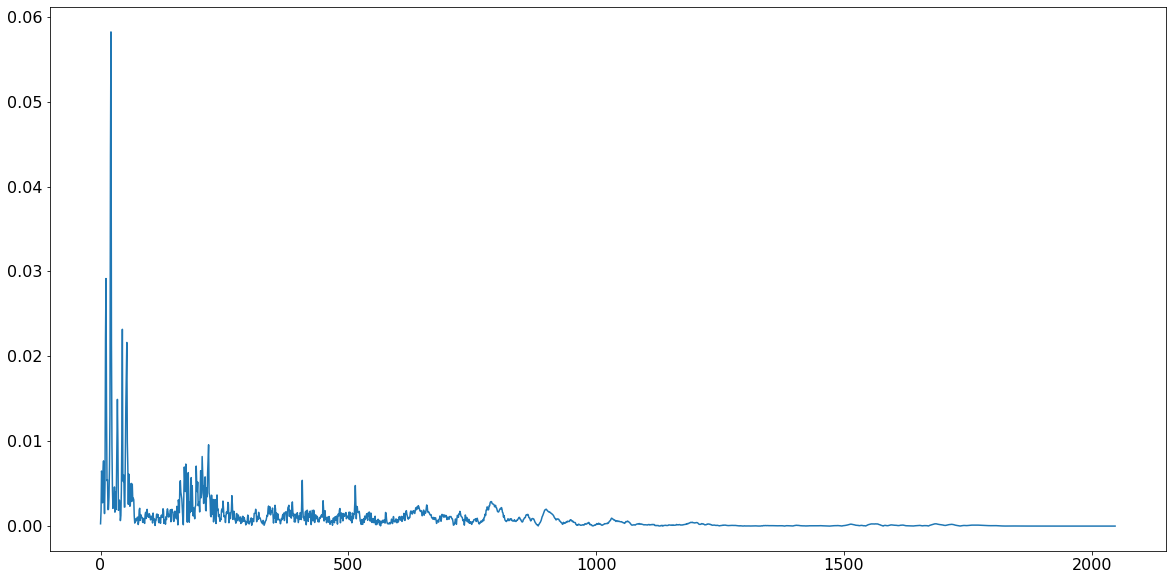

In [110]:
plt.plot(f)